# This notebook has been released on Google collab as it was faster than executing locally.

In [1]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0, alsologtostdout=False)
print("Tensforflow version :", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensforflow version : 2.9.2
Num GPUs Available:  0


## Analysis and preprocessing of the source file

In [2]:
import pandas as pd
df = pd.read_csv('https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv', encoding='latin', quotechar='"').fillna('')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",,,
1,ham,Ok lar... Joking wif u oni...,,,
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,,,
3,ham,U dun say so early hor... U c already then say...,,,
4,ham,"Nah I don't think he goes to usf, he lives aro...",,,


In [3]:
df.shape

(5572, 5)

In [4]:
df['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

In [5]:
ham_count = df['v1'].value_counts()[0]
spam_count = df['v1'].value_counts()[1]
print("Percentage of spam messages is",str(round(spam_count/(spam_count+ham_count)*100,2))+'%')

Percentage of spam messages is 13.41%


### The dataset is unbalanced with 86,59% of ham and 13,41% of spam messages.

## Preprocessing

First we clean up the columns it self.

In [6]:
df[df['Unnamed: 2']!=''].head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,,
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",,
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",,
899,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",
1038,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""
1127,ham,"Height of \Oh shit....!!\"" situation: A guy th...",".;-):-D""",,
1266,ham,\Hey sorry I didntgive ya a a bellearlier hunny,just been in bedbut mite go 2 thepub l8tr if u...,,
1384,ham,"Storming msg: Wen u lift d phne, u say \HELLO\...","bt not his girlfrnd... G o o d n i g h t . . .@""",,


Here we can see that 'Unnamed' columns contains other parts of the messages. We choose to concatenate it with first part of the message and to rename columns as well.

In [7]:
df["v2"] = df['v2'].astype("string") + " " + df['Unnamed: 2'].astype("string") + " " + df['Unnamed: 3'].astype("string") + " " + df['Unnamed: 4'].astype("string")
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df.rename(columns={'v1':'Category', 'v2':'Message'}, inplace=True)
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Then we cleanup the content of the Message column using spacy library, English language.

In [8]:
# !python -m spacy download en_core_web_sm -q

In [9]:
# Import Spacy and English initialisation
import en_core_web_sm
nlp = en_core_web_sm.load()

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [10]:
# Import Stop words 
from spacy.lang.en.stop_words import STOP_WORDS

In [11]:
df["Message_clean"] = df["Message"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
print("Cleaning Step 1 ok...")
df["Message_clean"] = df["Message_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
print("Cleaning Step 2 ok...")
df["Message_clean"] = df["Message_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
print("Cleaning Step 3 ok.")
df.head()

Cleaning Step 1 ok...
Cleaning Step 2 ok...
Cleaning Step 3 ok.


,Category,Message,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live


In [12]:
print("Row count before row cleaning:", df.shape[0])
# We remove rows with empty messages
df = df[df["Message_clean"].isna()==False]
print("Row count after row cleaning:", df.shape[0])

Row count before row cleaning: 5572
Row count after row cleaning: 5572


No row with empty messages after having removed the stop words. Fine.

In [13]:
# Instanciate the tokenizer by keeping the first 3000 words found.
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=3000) 
tokenizer.fit_on_texts(df["Message_clean"])
df["Message_encoded"] = tokenizer.texts_to_sequences(df["Message_clean"])
df.head()

,Category,Message,Message_clean,Message_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,"[233, 446, 461, 947, 35, 52, 205, 948, 79, 237..."
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[9, 193, 290, 1, 1460]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[12, 300, 3, 535, 659, 33, 1461, 858, 423, 146..."
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,"[1, 125, 150, 2378, 1, 85]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,"[710, 22, 660, 128]"


In [14]:
print("Row count before row cleaning:", df.shape[0])
df["Message_len"] = df["Message_encoded"].apply(lambda x: len(x))
df = df[df["Message_len"]!=0]
print("Row count after row cleaning:", df.shape[0])

Row count before row cleaning: 5572
Row count after row cleaning: 5504


Some empty rows are removed because all the words have not been tokenized.

In [15]:
# Padding of the messages tokens in order for the messages tokens list to have all the same length
messages_pad = tf.keras.preprocessing.sequence.pad_sequences(df["Message_encoded"], padding="post")
messages_pad.shape

(5504, 58)

Maximum count of words/tokens in messages is 58.

Now that the Message column has been encoded, we need to encode the Category one : 'spam' -> 1, 'ham' -> 0.

In [16]:
df['spam'] = df['Category'].apply(lambda x:1 if x=='spam' else 0)
df.head()

<ipython-input-16-78403eefa430>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['spam'] = df['Category'].apply(lambda x:1 if x=='spam' else 0)


,Category,Message,Message_clean,Message_encoded,Message_len,spam
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,"[233, 446, 461, 947, 35, 52, 205, 948, 79, 237...",12,0
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[9, 193, 290, 1, 1460]",5,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[12, 300, 3, 535, 659, 33, 1461, 858, 423, 146...",22,1
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,"[1, 125, 150, 2378, 1, 85]",6,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,"[710, 22, 660, 128]",4,0


We can then now create the tensors to be used by the DL models.

In [17]:
full_ds = tf.data.Dataset.from_tensor_slices((messages_pad, df['spam']))
full_ds

<TensorSliceDataset element_spec=(TensorSpec(shape=(58,), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

# Training of the model with DL RNN models

In [18]:
# Train Test Split
BATCH_SIZE = 64
TRAIN_SIZE = int(0.7*df.shape[0])
VAL_SIZE = int(0.15*df.shape[0])
TEST_SIZE =  df.shape[0] - TRAIN_SIZE - VAL_SIZE

train_data = full_ds.take(TRAIN_SIZE).shuffle(TRAIN_SIZE, seed=0)
train_data = train_data.batch(BATCH_SIZE)

val_data = full_ds.skip(TRAIN_SIZE).take(VAL_SIZE)
val_data = val_data.batch(BATCH_SIZE)

test_data = full_ds.skip(TRAIN_SIZE).skip(VAL_SIZE)

In [19]:
for message, category in train_data.take(1):
  print(message, category)

tf.Tensor(
[[1130 1298 1902 ...    0    0    0]
 [ 287 1236  104 ...    0    0    0]
 [ 735  376  161 ...    0    0    0]
 ...
 [  22  327  142 ...    0    0    0]
 [   2  388 1327 ...    0    0    0]
 [   1    5    3 ...    0    0    0]], shape=(64, 58), dtype=int32) tf.Tensor(
[0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0], shape=(64,), dtype=int64)


## Model is unbalanced as we have seen previously. We add some weight to the model in order to indicate this unbalancing.

In [20]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
weights = compute_class_weight(class_weight='balanced', classes=np.unique(df["spam"]), y=df["spam"])
weights = dict(zip(np.unique(df["spam"]), weights))
weights

{0: 0.5783942833123161, 1: 3.689008042895442}

## Attempt with Simple RNN

In [21]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

vocab_size = len(tokenizer.word_index)
model = tf.keras.Sequential([
                  # Word Embedding layer           
                  Embedding(vocab_size+1, 64, input_shape=[message.shape[1],],name="embedding"),
                  # Gobal average pooling
                  SimpleRNN(units=64, return_sequences=True), # maintains the sequential nature
                  SimpleRNN(units=32, return_sequences=False), # returns the last output
                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),

                  # output layer with 1 neuron containing the value between 0 (ham value) and 1 (spam value).
                  Dense(1, activation="sigmoid")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 58, 64)            530176    
                                                                 
 simple_rnn (SimpleRNN)      (None, 58, 64)            8256      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 542,209
Trainable params: 542,209
Non-trai

In [22]:
optimizer= tf.keras.optimizers.Adam()

# We choose to estimate a binary (0, 1) value at the end.
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.binary_crossentropy,
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [23]:
# Model training 
model.fit(train_data,
          epochs=20, 
          validation_data=val_data,
          class_weight=weights)

Epoch 1/20
61/61 [==============================] - 5s 51ms/step - loss: 0.5587 - binary_accuracy: 0.6025 - val_loss: 0.6210 - val_binary_accuracy: 0.9042
Epoch 2/20
61/61 [==============================] - 3s 44ms/step - loss: 0.3645 - binary_accuracy: 0.9569 - val_loss: 0.4159 - val_binary_accuracy: 0.9588
Epoch 3/20
61/61 [==============================] - 3s 45ms/step - loss: 0.1878 - binary_accuracy: 0.9834 - val_loss: 0.2004 - val_binary_accuracy: 0.9673
Epoch 4/20
61/61 [==============================] - 3s 42ms/step - loss: 0.2582 - binary_accuracy: 0.9437 - val_loss: 0.1807 - val_binary_accuracy: 0.9697
Epoch 5/20
61/61 [==============================] - 3s 43ms/step - loss: 0.1419 - binary_accuracy: 0.9779 - val_loss: 0.1364 - val_binary_accuracy: 0.9758
Epoch 6/20
61/61 [==============================] - 4s 65ms/step - loss: 0.1195 - binary_accuracy: 0.9834 - val_loss: 0.1843 - val_binary_accuracy: 0.9515
Epoch 7/20
61/61 [==============================] - 4s 66ms/step - los

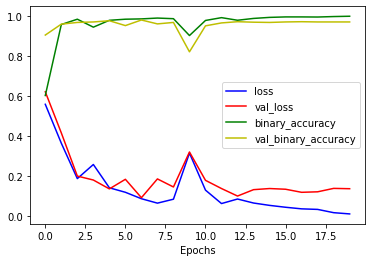

In [24]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(model.history.history["loss"], color="b", label = "loss")
plt.plot(model.history.history["val_loss"], color="r", label = "val_loss")
plt.plot(model.history.history["binary_accuracy"], color="g", label = "binary_accuracy")
plt.plot(model.history.history["val_binary_accuracy"], color="y", label = "val_binary_accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.show()

## Simple RNN Model is overfitting as the validation loss curve does not tend to follow the loss curve at the end. Let's try to introduce some dropout to fight this overfitting.

In [25]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

vocab_size = len(tokenizer.word_index)
model_rnn_do = tf.keras.Sequential([
                  # Word Embedding layer           
                  Embedding(vocab_size+1, 64, input_shape=[message.shape[1],],name="embedding"),
                  # Gobal average pooling
                  SimpleRNN(units=64, return_sequences=True), # maintains the sequential nature
                  SimpleRNN(units=32, return_sequences=False), # returns the last output
                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),

                  Dropout(0.2),
                          
                  # output layer with 1 neuron containing the value between 0 (ham value) and 1 (spam value).
                  Dense(1, activation="sigmoid")
])
model_rnn_do.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 58, 64)            530176    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 58, 64)            8256      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [26]:
optimizer= tf.keras.optimizers.Adam()

# We choose to estimate a binary (0, 1) value at the end.
model_rnn_do.compile(optimizer=optimizer,
              loss=tf.keras.losses.binary_crossentropy,
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [27]:
# Model training 
model_rnn_do.fit(train_data,
          epochs=15, 
          validation_data=val_data,
          class_weight=weights)

Epoch 1/15
61/61 [==============================] - 5s 49ms/step - loss: 0.5238 - binary_accuracy: 0.8668 - val_loss: 0.2960 - val_binary_accuracy: 0.9164
Epoch 2/15
61/61 [==============================] - 3s 44ms/step - loss: 0.3322 - binary_accuracy: 0.9411 - val_loss: 0.3404 - val_binary_accuracy: 0.9236
Epoch 3/15
61/61 [==============================] - 3s 44ms/step - loss: 0.3292 - binary_accuracy: 0.9367 - val_loss: 0.2774 - val_binary_accuracy: 0.9261
Epoch 4/15
61/61 [==============================] - 3s 43ms/step - loss: 0.3344 - binary_accuracy: 0.9403 - val_loss: 0.3128 - val_binary_accuracy: 0.9236
Epoch 5/15
61/61 [==============================] - 3s 42ms/step - loss: 0.3247 - binary_accuracy: 0.9413 - val_loss: 0.3272 - val_binary_accuracy: 0.9236
Epoch 6/15
61/61 [==============================] - 5s 89ms/step - loss: 0.3207 - binary_accuracy: 0.9416 - val_loss: 0.2952 - val_binary_accuracy: 0.9236
Epoch 7/15
61/61 [==============================] - 3s 43ms/step - los

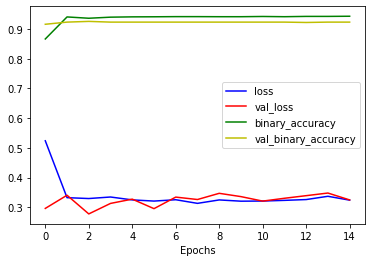

In [28]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(model_rnn_do.history.history["loss"], color="b", label = "loss")
plt.plot(model_rnn_do.history.history["val_loss"], color="r", label = "val_loss")
plt.plot(model_rnn_do.history.history["binary_accuracy"], color="g", label = "binary_accuracy")
plt.plot(model_rnn_do.history.history["val_binary_accuracy"], color="y", label = "val_binary_accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.show()

# Adding some dropout helped a bit to stabilize the model. Curves are good.


## Let's try with LSTM model to compare with.

In [29]:
from tensorflow.keras.layers import Embedding, Dense, LSTM

vocab_size = len(tokenizer.word_index)
model_lstm = tf.keras.Sequential([
                  # Word Embedding layer           
                  Embedding(vocab_size+1, 64, input_shape=[message.shape[1],],name="embedding"),
                  # Gobal average pooling
                  LSTM(units=64, return_sequences=True), # maintains the sequential nature
                  LSTM(units=32, return_sequences=False), # returns the last output
                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),

                  # output layer with 1 neuron containing the value between 0 (ham value) and 1 (spam value).
                  Dense(1, activation="sigmoid")
])
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 58, 64)            530176    
                                                                 
 lstm (LSTM)                 (None, 58, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 576,289
Trainable params: 576,289
Non-tr

In [30]:
optimizer= tf.keras.optimizers.Adam()

# We choose to estimate a binary (0, 1) value at the end.
model_lstm.compile(optimizer=optimizer,
              loss=tf.keras.losses.binary_crossentropy,
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [31]:
model_lstm.fit(train_data,
              epochs=20, 
              validation_data=val_data,
              class_weight=weights)

Epoch 1/20
61/61 [==============================] - 11s 114ms/step - loss: 0.6917 - binary_accuracy: 0.6937 - val_loss: 0.6628 - val_binary_accuracy: 0.8582
Epoch 2/20
61/61 [==============================] - 6s 97ms/step - loss: 0.5727 - binary_accuracy: 0.9089 - val_loss: 0.1610 - val_binary_accuracy: 0.9806
Epoch 3/20
61/61 [==============================] - 6s 98ms/step - loss: 0.1787 - binary_accuracy: 0.9743 - val_loss: 0.1567 - val_binary_accuracy: 0.9685
Epoch 4/20
61/61 [==============================] - 6s 96ms/step - loss: 0.1585 - binary_accuracy: 0.9761 - val_loss: 0.1593 - val_binary_accuracy: 0.9685
Epoch 5/20
61/61 [==============================] - 6s 100ms/step - loss: 0.1461 - binary_accuracy: 0.9774 - val_loss: 0.1615 - val_binary_accuracy: 0.9685
Epoch 6/20
61/61 [==============================] - 6s 94ms/step - loss: 0.1410 - binary_accuracy: 0.9787 - val_loss: 0.1526 - val_binary_accuracy: 0.9697
Epoch 7/20
61/61 [==============================] - 6s 93ms/step - 

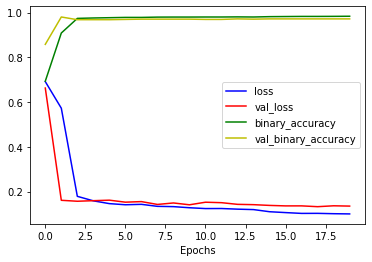

In [32]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(model_lstm.history.history["loss"], color="b", label = "loss")
plt.plot(model_lstm.history.history["val_loss"], color="r", label = "val_loss")
plt.plot(model_lstm.history.history["binary_accuracy"], color="g", label = "binary_accuracy")
plt.plot(model_lstm.history.history["val_binary_accuracy"], color="y", label = "val_binary_accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.show()

## LSTM model is pretty good after some epochs.

## Let's test the LSTM model on a sample test of the full Dataset.

In [33]:
X_test = []
y_test = []
for mess, spam in test_data.take(TEST_SIZE):
  X_test.append(mess)
  y_test.append(spam)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [34]:
# Let's check the count of spam messages in the test dataset
pd.value_counts(np.array(y_test))

0    717
1    110
dtype: int64

In [35]:
X_test

array([[ 190,  441,  636, ...,    0,    0,    0],
       [  87,  294,  346, ...,    0,    0,    0],
       [ 863,    1,   15, ...,    0,    0,    0],
       ...,
       [ 943,    0,    0, ...,    0,    0,    0],
       [ 113, 1348,   14, ...,    0,    0,    0],
       [2095,  312,    0, ...,    0,    0,    0]], dtype=int32)

In [36]:
# Let's evaluate the model with tes values
model_lstm.evaluate(X_test, y_test)

26/26 [==============================] - 1s 21ms/step - loss: 0.1647 - binary_accuracy: 0.9649


[0.1646621823310852, 0.9649335145950317]

In [37]:
# Getting y_pred by predicting over X_text and flattening it
y_pred=(model_lstm.predict(X_test) > 0.5).astype("int32")
# It requires to be in one-dimensional array , for easy manipulation
y_pred = y_pred.flatten()

26/26 [==============================] - 1s 19ms/step


Text(33.0, 0.5, 'Actual')

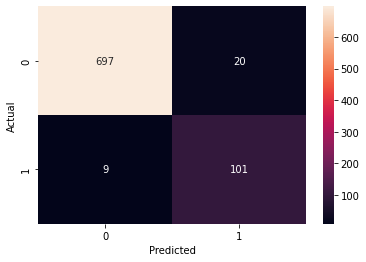

In [38]:
from sklearn.metrics import confusion_matrix, classification_report
# Let's see the results with confusion matrix 
cm = confusion_matrix(y_test,y_pred)
import seaborn as sns
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

## Let's test the Simple RNN Dropout model on a sample test of the full Dataset.

In [39]:
# Let's evaluate the model with tes values
model_rnn_do.evaluate(X_test, y_test)

26/26 [==============================] - 0s 11ms/step - loss: 0.3136 - binary_accuracy: 0.9287


[0.31356945633888245, 0.9286577701568604]

In [40]:
# Getting y_pred by predicting over X_text and flattening it
y_pred=(model_rnn_do.predict(X_test) > 0.5).astype("int32")
# It requires to be in one-dimensional array , for easy manipulation
y_pred = y_pred.flatten()

26/26 [==============================] - 1s 10ms/step


Text(33.0, 0.5, 'Actual')

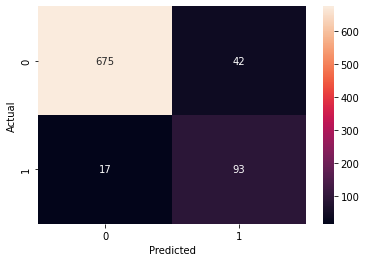

In [41]:
from sklearn.metrics import confusion_matrix, classification_report
# Let's see the results with confusion matrix 
cm = confusion_matrix(y_test,y_pred)
import seaborn as sns
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# The LSTM model is better than the simple RNN dropout model !!!

## Let's try to use some BERT processer and encoder in the next notebook !